## Self Supervised Learning 

## What is self supervised learing?
Self-supervised learning is a machine learing technique where the training data is labeled by the machine itself. Once we learn the representation of the data or features, we can use tranfer learing to fine tune the model for the task we want to solve.
 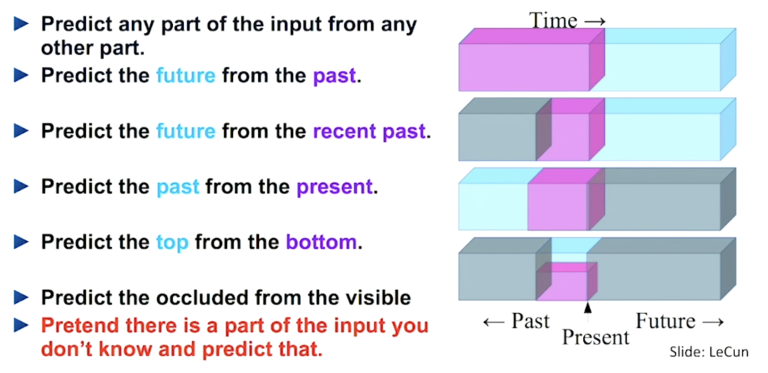

## Why self supervised learing?

* Self-supervised learning is a type of unsupervised learning. It is a way to learn useful features without human annotation.

* Data pre-processing is a time consuming and expensive process. Self-supervised learning can help us to reduce the cost of data preprocessing.



## How self supervised learing works?

write the steps here

* Step 1: Collect the data withour labels
* Step 2: Create a model
* Step 3: Train the model
* Step 4: Fine tune the model for the task we want to solve
* Step 5: Predict the model on test data
* Step 6: Evaluate the model


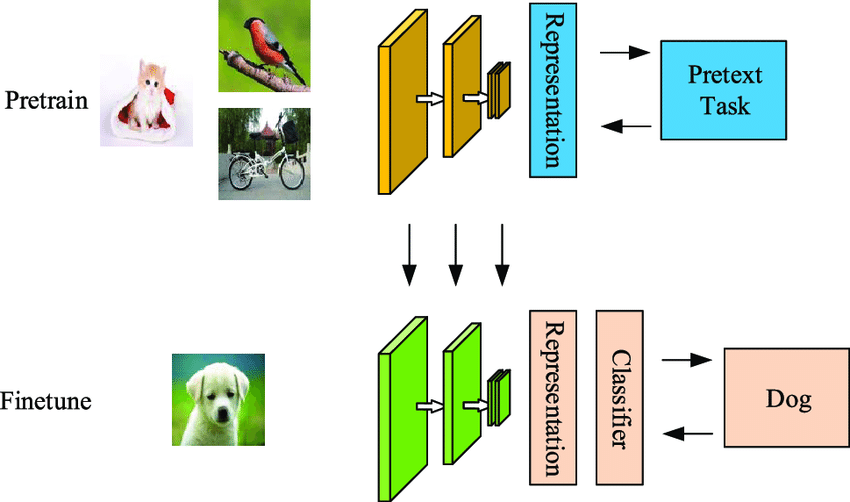

## Task 1: Image Classification using supervised learning 

### data: https://www.kaggle.com/c/dogs-vs-cats/data
### train set size: 10 dog + 10 cat
### test set size: 100 dog+cat


In [1]:
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image


In [2]:

train_path = '/home/rishabh.mondal/label_image_FT'



### for class labels 

In [3]:
def class_label(train_path):
    class_labels = {'cat': 0, 'dog': 1}
    image_paths = []
    labels = []
    for class_name, class_label in class_labels.items():
        class_dir = os.path.join(train_path, class_name)
        class_image_paths = glob.glob(os.path.join(class_dir, '*.jpg'))
        image_paths.extend(class_image_paths)
        labels.extend([class_label] * len(class_image_paths))
    return image_paths, labels    
    # print('Number of images found: ', len(image_paths))
    # print('number of 0s: ', labels.count(0))
    # print('number of 1s: ', labels.count(1))

### Function for display images 

In [4]:
import random

def display_images(image_paths, labels):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.subplots_adjust(hspace=0.5)
    data = list(zip(image_paths, labels))
    random.shuffle(data)
    image_paths, labels = zip(*data)
    for i in range(10): 
        ax = axes[i // 5, i % 5]
        img = cv2.imread(image_paths[i])
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
        ax.set_title('Label: ' + str(labels[i]))
        ax.axis('off')  


### Evaluate and plot 


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

def evaluate_and_plot(y_true, y_pred, class_labels):
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average='binary')
    plt.figure(figsize=(3, 2))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}")

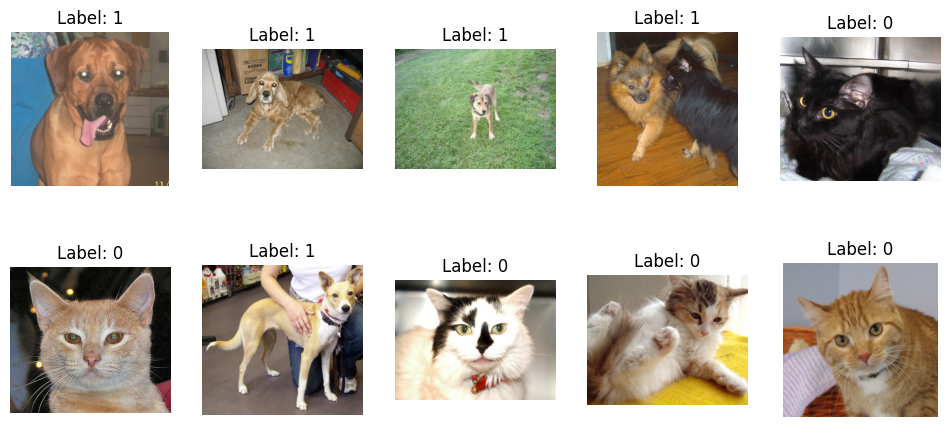

In [6]:

image_paths, labels=class_label(train_path)
display_images(image_paths, labels)


### code for transform the data

In [7]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

### trainloader

In [8]:
train_data = datasets.ImageFolder('/home/rishabh.mondal/label_image_FT', transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

### simple vgg like structure

In [9]:
class VGGLike(nn.Module):
    def __init__(self,num_classes):
        super(VGGLike,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            # nn.Conv2d(128,128,kernel_size=3,padding=1),
            # nn.ReLU(inplace=True),  
            # nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7,7))

        self.classifier = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096,num_classes),
        )
    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x


### gpu code

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [11]:
# print model
model = VGGLike(num_classes=2)
model = model.to(device)
print(model)

VGGLike(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1

### model onax representation

In [12]:

# import torch.onnx

# dummy_input = torch.randn(1, 3, 224, 224)  

# # Export the model to ONNX
# onnx_file_path = "your_model.onnx"  
# torch.onnx.export(model, dummy_input, onnx_file_path, verbose=False)
# print("Model exported to ONNX successfully.")


### train loader

In [13]:
#define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_list = []
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_list.append(epoch_loss)
    
    print('Epoch: %d | Loss: %.4f' % (epoch + 1, epoch_loss))


Epoch: 1 | Loss: 0.6929
Epoch: 2 | Loss: 0.7563
Epoch: 3 | Loss: 0.7824
Epoch: 4 | Loss: 0.7096
Epoch: 5 | Loss: 0.6925
Epoch: 6 | Loss: 0.6961
Epoch: 7 | Loss: 0.6917
Epoch: 8 | Loss: 0.6898
Epoch: 9 | Loss: 0.6759
Epoch: 10 | Loss: 0.6930
Epoch: 11 | Loss: 0.7695
Epoch: 12 | Loss: 0.6937
Epoch: 13 | Loss: 0.6815
Epoch: 14 | Loss: 0.6944
Epoch: 15 | Loss: 0.6940
Epoch: 16 | Loss: 0.6941
Epoch: 17 | Loss: 0.6915
Epoch: 18 | Loss: 0.6898
Epoch: 19 | Loss: 0.6948
Epoch: 20 | Loss: 0.6935
Epoch: 21 | Loss: 0.6953
Epoch: 22 | Loss: 0.6947
Epoch: 23 | Loss: 0.6937
Epoch: 24 | Loss: 0.6926
Epoch: 25 | Loss: 0.6934
Epoch: 26 | Loss: 0.6930
Epoch: 27 | Loss: 0.6951
Epoch: 28 | Loss: 0.6938
Epoch: 29 | Loss: 0.6929
Epoch: 30 | Loss: 0.6940
Epoch: 31 | Loss: 0.6939
Epoch: 32 | Loss: 0.6935
Epoch: 33 | Loss: 0.6947
Epoch: 34 | Loss: 0.6974
Epoch: 35 | Loss: 0.6903
Epoch: 36 | Loss: 0.6909
Epoch: 37 | Loss: 0.6912
Epoch: 38 | Loss: 0.6944
Epoch: 39 | Loss: 0.6929
Epoch: 40 | Loss: 0.6934
Epoch: 41

### Loss plot

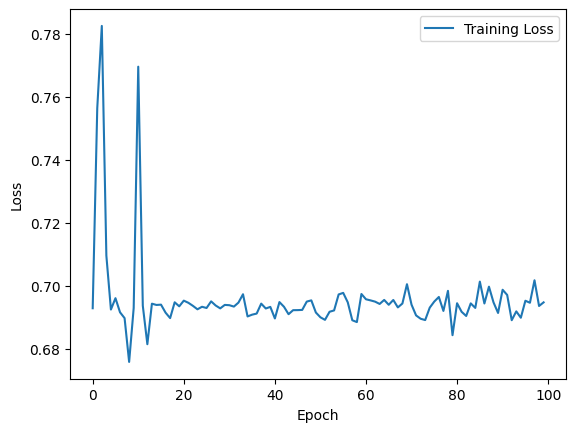

In [14]:
plt.plot(loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [15]:
# predict on test set
test_data = datasets.ImageFolder('/home/rishabh.mondal/test_images_CD', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


In [16]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in test_loader:  
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  

        outputs = model(inputs)  
        _, predicted = outputs.max(1)

        total += labels.size(0)  
        correct += (predicted == labels).sum().item()  
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())
accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')



Validation Accuracy: 60.00%


Accuracy: 0.6
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


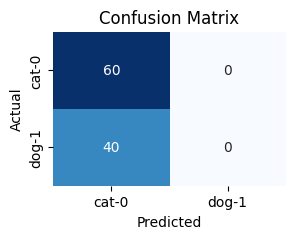

In [17]:
evaluate_and_plot(true_labels, predicted_labels, class_labels=["cat-0", "dog-1"])


## Task 2: Image Classification using self supervised learning

### images to grayscale

In [18]:
import os
from PIL import Image

data_dir = '/home/rishabh.mondal/ssl_dataset'
image_paths = os.listdir(data_dir)

valid_image_paths = []

for img_path in image_paths:
    try:
        Image.open(os.path.join(data_dir, img_path))
        valid_image_paths.append(img_path)
    except Exception as e:
        print(f"Error opening {img_path}: {str(e)}")

print(f"Total images: {len(image_paths)}")
print(f"Valid images: {len(valid_image_paths)}")

# Remove the two problematic image files
problematic_images = ['11702.jpg', '666 - Copy.jpg']
for img in problematic_images:
    if img in valid_image_paths:
        valid_image_paths.remove(img)

print(f"Valid images after removal: {len(valid_image_paths)}")

# Now, you can create your dataset with the updated valid image paths.


Total images: 9998
Valid images: 9998
Valid images after removal: 9998


In [19]:


class UnlabeledColorizationDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_paths = os.listdir(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_paths[idx])
        color_image = Image.open(img_path)

        # Convert the color image to RGB format (3 channels)
        color_image = color_image.convert('RGB')

        if self.transform:
            color_image = self.transform(color_image)

        transform = transforms.Grayscale(num_output_channels=1)
        grayscale_image = transform(color_image)

        return grayscale_image, color_image


torch.Size([1, 224, 224])
torch.Size([3, 224, 224])


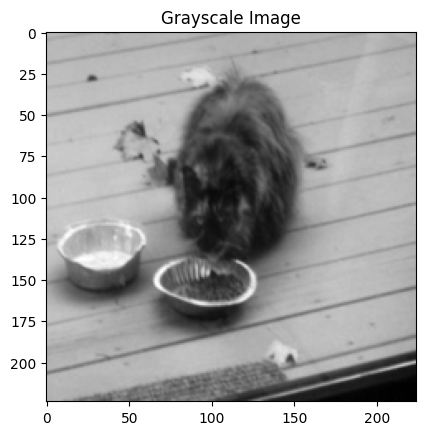

In [20]:
unlabeled_data = UnlabeledColorizationDataset('/home/rishabh.mondal/ssl_dataset/', transform=transform)
len(unlabeled_data)
#show the image
grayscale_image, color_image = unlabeled_data[0]
plt.imshow(grayscale_image.squeeze(), cmap='gray')
plt.title('Grayscale Image')
#show the dimension of the image
print(grayscale_image.shape)
print(color_image.shape)

### model for image colorization 

In [26]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()

        # Encoder (Grayscale to Features)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder (Features to Color)
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),  # Output 3 channels (RGB)
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # Upsample to match the desired size
        )

    def forward(self, grayscale_image):
        # Add a batch dimension
        grayscale_image = grayscale_image.unsqueeze(0)
        
        # Encoder
        features = self.encoder(grayscale_image)
        # Decoder
        color_image = self.decoder(features)
        
        # Remove the batch dimension from the output
        color_image = color_image.squeeze(0)
        
        return color_image



In [22]:
# class ColorizationModel(nn.Module):
#     def __init__(self,num_classes):
#         super(ColorizationModel, self).__init__()

#         # Encoder (Grayscale to Features)
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#         # Decoder (Features to Color)
#         self.decoder = nn.Sequential(
#             nn.Conv2d(128, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 3, kernel_size=3, padding=1),  
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # Upsample to match the desired size
#         )

#         #classification head
#         self.classification_head = nn.Sequential(
#         nn.AdaptiveAvgPool2d(1),  # Global average pooling
#         nn.Flatten(),
#         nn.Linear(128, num_classes)  # Adjust input size based on your encoder's output size
#     )
        
#     def forward(self, grayscale_image):
#         # Add a batch dimension
#         grayscale_image = grayscale_image.unsqueeze(0)
        
#         # Encoder
#         features = self.encoder(grayscale_image)
#         # Decoder
#         color_image = self.decoder(features)
        
#         # Remove the batch dimension from the output
#         color_image = color_image
        
#         return color_image,features
# class ClassificationtionHead(nn.Module):
#     def __init__(self,num_classes):
#         super(ClassificationtionHead,self).__init__()
#         self.fc = nn.Linear(128, num_classes)
#     def forward(self,features):
#         return self.fc(features)
    

In [27]:
model = ColorizationModel()
model = model.to(device)
print(model)

ColorizationModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Upsample(scale_factor=2.0, mode='bilinear')
  )
)


In [24]:

# dummy_input = torch.randn(1, 224, 224)  # Batch size 1, 1 channel, 224x224 input

# # Provide the path for the ONNX model
# onnx_model_path = "colorization_model.onnx"

# # Export the model to ONNX format
# torch.onnx.export(model, dummy_input, onnx_model_path, verbose=False)
# print(f"ONNX model saved to: {onnx_model_path}")


In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
loss_list_ssl = []

model.train()
for epoch in range(10):
    running_loss =0.0
    for grayscale_image, color_image in unlabeled_data:
        grayscale_image, color_image = grayscale_image.to(device), color_image.to(device)
        optimizer.zero_grad()
        
        outputs = model(grayscale_image)
        loss = criterion(outputs, color_image)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(unlabeled_data)
    loss_list_ssl.append(epoch_loss)
    print('Epoch: %d | Loss: %.4f' % (epoch + 1, epoch_loss))

    
torch.save(model.encoder.state_dict(), 'encoder.pth')



Epoch: 1 | Loss: 0.0058
Epoch: 2 | Loss: 0.0054
Epoch: 3 | Loss: 0.0053
Epoch: 4 | Loss: 0.0053
Epoch: 5 | Loss: 0.0052
Epoch: 6 | Loss: 0.0052
Epoch: 7 | Loss: 0.0052
Epoch: 8 | Loss: 0.0052
Epoch: 9 | Loss: 0.0052
Epoch: 10 | Loss: 0.0052


In [31]:
class ClassificationHead(nn.Module):
    def __init__(self, num_classes, feature_dim):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, features):
        return self.fc(features)


In [37]:
saved_state_dict = torch.load('encoder.pth')

# Initialize a new state_dict for your model
new_state_dict = model.state_dict()

classification_head = ClassificationHead(num_classes=2, feature_dim=128)
# combined_model=nn.Sequential(new_state_dict,classification_head)
optimizer = optim.Adam(classification_head.parameters(), lr=0.001)  # Only optimize the classification head
criterion = nn.CrossEntropyLoss()  # Appropriate loss function for classification

combined_model.train()
classification_head.train()

for epoch in range(10):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)

        features = new_state_dict(inputs)  # Extract features using the pre-trained encoder
        logits = classification_head(features)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()


NameError: name 'combined_model' is not defined

In [ ]:
# #plot the loss
# plt.plot(loss_list_ssl, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend();

In [ ]:
#save the plot as png   
plt.savefig('ssl_loss.png')


In [ ]:
#save the model
torch.save(model.state_dict(), 'ssl_model.pth')